### **Figure 2: T1w/T2w similarity aligns with inter-areal similarity of myelin basic protein (MBP) gene expression**

#### **2.1 Setup**

In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2

# Import helper functions
import sys
sys.path.append('code')
from plotting_helpers import *
from stats_helpers import *
from MIND_helpers import *
from preprocessing_helpers import *

#### **2.2 Visualise slices**

Visualise equivalent slices in:
1. A Myelin Basic Protein (MBP) mRNA volume from a single 4-year-old male marmoset
2. An average adult T1w/T2w image formed by taking the mean across spatially co-registered scans above 1.75 years of age (N=340, mean age = 4.3 years)

These scans were preprocessed elsewhere, so we just load them in

In [2]:
# Load MBP data
MBP_4Y_path = 'data/MBP_4Y_img.nii'

# Load T1w/T2w data
adult_t12_path = 'data/mean_adult_t12_img.nii.gz'

# Load parcellation data
parc_img_path = 'data/sp2_label_512_v1.0.0.nii.gz'

# Load lookup table
lut = pd.read_csv('data/lut_master.csv', index_col=0)

Now visualise a saggital slice windowed around one or more regions of interest in adult MBP expression and T1w/T2w images. Within this window, the ROI is highlighted using a coloured overlay for ease of visualisation

A4ab_L (left primary motor cortex) is used as an example

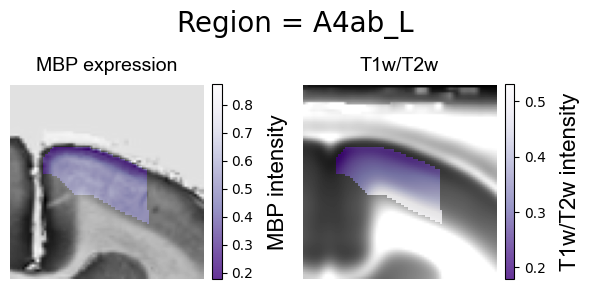

In [ ]:
# Load additional packages
from scipy.ndimage import gaussian_filter
import matplotlib.cm as cm
import matplotlib.colors as colors

# Set size of visualisation window
A = 40

# List of ROIs to visualise
rois = ['A4ab_L']

for roi in rois:

    # Get region centroid to centre visualisation window
    bm_code = lut['bm_code'][np.where(lut['Label'] == roi)[0][0]]
    parc_img_data = nib.load(parc_img_path).get_fdata()
    parc_img_data_padded = np.pad(parc_img_data, pad_width=40)
    roi_mask = parc_img_data_padded == bm_code
    parc_voxels = np.where(roi_mask)
    x_avg = round(np.mean(parc_voxels[0]))
    y_avg = round(np.mean(parc_voxels[1]))
    z_avg = round(np.mean(parc_voxels[2]))

    # Initialise plot
    fig, axes = plt.subplots(1, 2, figsize=(6, 5), gridspec_kw={'width_ratios': [1, 1]})


    # ----- MBP ----- #

    # Load and pad image
    MBP_4Y_data = nib.load(MBP_4Y_path).get_fdata()
    img_data = np.pad(MBP_4Y_data, pad_width=40)

    # Extract window around centroid in original image
    slice_img = img_data[x_avg - A:x_avg + A, y_avg, z_avg - A:z_avg + A]
    slice_img = np.rot90(slice_img, k=3)

    # Extract overlay to highlight the region
    mask_slice = roi_mask[x_avg - A:x_avg + A, y_avg, z_avg - A:z_avg + A]
    mask_slice = np.rot90(mask_slice, k=3)
    roi_masked = np.zeros_like(slice_img)
    roi_masked[mask_slice] = slice_img[mask_slice]
    
    # Set colourbar min and max based on values in overlay
    vmin, vmax = roi_masked[mask_slice].min(), roi_masked[mask_slice].max()
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Plot slice and overlay
    ax_img = axes[0]
    ax_img.imshow(slice_img, cmap='gray', origin='lower')
    im2 = ax_img.imshow(
        np.ma.masked_where(~mask_slice, roi_masked),
        cmap='Purples_r',
        origin='lower',
        alpha=0.8,
        norm=norm
    )
    ax_img.set_title('MBP expression', fontsize=14, pad=10, fontfamily='Arial')
    ax_img.axis('off')
    ax_img.set_aspect('equal')

    # Set colorbar
    cbar = plt.colorbar(im2, ax=ax_img, fraction=0.046, pad=0.04)
    cbar.set_label(f"MBP intensity", fontsize=16, fontfamily='Arial', labelpad=10)
    cbar.ax.tick_params(labelsize=10)


    # ----- T1w/T2w ----- #

    # Load and pad image
    t12_adult_data = nib.load(adult_t12_path).get_fdata()
    img_data = np.pad(t12_adult_data, pad_width=40)

    # Clip entire T1w/T2w image to 0, 80 pctiles to attenuate bright bone / soft tissue signal
    img_data = np.clip(img_data, np.percentile(img_data, 0), np.percentile(img_data, 80))

    # Extract window around centroid in original image
    slice_img = img_data[x_avg - A:x_avg + A, y_avg, z_avg - A:z_avg + A]
    slice_img = np.rot90(slice_img, k=3)
    
    # Extract overlay to highlight the region
    mask_slice = roi_mask[x_avg - A:x_avg + A, y_avg, z_avg - A:z_avg + A]
    mask_slice = np.rot90(mask_slice, k=3)
    roi_masked = np.zeros_like(slice_img)
    roi_masked[mask_slice] = slice_img[mask_slice]
    
    # Set colourbar min and max based on values in overlay
    # Use 90th pctile of intracortical values so that hyperintensity near
    # white matter surface does not use up the entire colourbar range
    vmin = roi_masked[mask_slice].min()
    vmax = np.percentile(roi_masked[mask_slice], 90)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)

    # Plot overlay
    ax_img = axes[1]
    ax_img.imshow(slice_img, cmap='gray', origin='lower')
    im2 = ax_img.imshow(
        np.ma.masked_where(~mask_slice, roi_masked),
        cmap='Purples_r',
        origin='lower',
        alpha=0.8,
        norm=norm
    )
    ax_img.set_title('T1w/T2w', fontsize=14, pad=10, fontfamily='Arial')
    ax_img.axis('off')
    ax_img.set_aspect('equal')

    # Set colorbar
    cbar = plt.colorbar(im2, ax=ax_img, fraction=0.046, pad=0.04)
    cbar.set_label(f"T1w/T2w intensity", fontsize=16, fontfamily='Arial', labelpad=10)
    cbar.ax.tick_params(labelsize=10)

    # Plot
    plt.suptitle(f'Region = {roi}', fontsize=20, y=0.8)
    plt.tight_layout()

    plt.show()


#### **2.3 Quantitative comparison of MBP expression and T1w/T2w**

Extract voxel values from MBP_4Y image 

In [ ]:
# Extract voxels
MBP_4Y_vox = extract_voxels(
    MBP_4Y_path,
    parc_img_path,
    lut,
    'ROI','Side','bm_code'
)

# Remove outlier values caused by slice artefacts
MBP_4Y_vox = MBP_4Y_vox[MBP_4Y_vox.Value < 0.8]

# Save
MBP_dir = 'output/MBP/'
os.makedirs(MBP_dir, exist_ok=True)
MBP_4Y_vox.to_csv('output/MBP/MBP_4Y_vox.csv')

100%|██████████| 230/230 [00:10<00:00, 21.60it/s]


Correlate mean MBP expression and mean T1w/T2w across the cortex

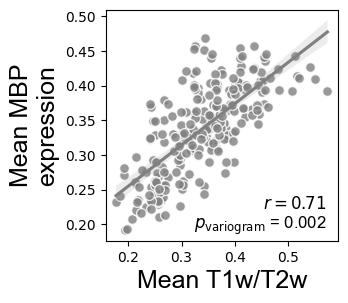

In [ ]:
# Get MBP mean
MBP_4Y_vox = pd.read_csv('output/MBP/MBP_4Y_vox.csv', index_col=0)
MBP_4Y_mean = MBP_4Y_vox.groupby('Label', sort=False).Value.mean()
MBP_4Y_mean.to_csv('output/MBP/MBP_4Y_regional_mean.csv')

# Get T1w/T2w mean
t12_adult_mean = pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0)
t12_adult_mean = t12_adult_mean[t12_adult_mean.columns[0]].values

# ----- Plot correlation ----- #
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)

# Get r and p
r, p = get_brainsmashed_region_correlation_p_val(map_a = t12_adult_mean,
                                                 map_b = MBP_4Y_mean,
                                                 regions_ind = None,
                                                 dist = dist.values,
                                                 surrogates_filename = 'output/surrogates/mean_adult_t12_surrogates_lh.csv', 
                                                 lh=False,
                                                 n_perm=1000, 
                                                 test_type = 'two-tailed')

# Plot
df = pd.DataFrame({
        't12': pd.to_numeric(t12_adult_mean, errors='coerce'),
        'ISH': pd.to_numeric(MBP_4Y_mean, errors='coerce')
    })

plt.figure(figsize=(3, 3))
sns.regplot(x='t12', y='ISH', data=df, color='grey', marker='o', line_kws={'color': 'grey'}, scatter_kws={'s': 50, 'edgecolors': 'white'})
plt.xlabel(f'Mean T1w/T2w', fontsize=18, fontfamily='Arial')
plt.ylabel('Mean MBP\nexpression', fontsize=18, fontfamily='Arial')
ax = plt.gca(); x1, x2 = ax.get_xlim(); y1, y2 = ax.get_ylim()
xpos = x1 + 0.95*(x2-x1); ypos = y1 + 0.2*(y2-y1); ha, va = "right", "top"
p_text = '< 0.001' if p < 0.001 else f'= {p:.3f}'
ax.text(xpos, ypos, f'$r = {r:.2f}$\n$p_{{\\mathrm{{variogram}}}}$ {p_text}', ha=ha, va=va, fontsize=12, fontfamily='Arial')

plt.show()

#### **2.4 Quantitative comparison of MBP expression and T1w/T2w MIND networks**

Compute MBP MIND network

In [ ]:
# Ignore division by 0 errors (these are normal) 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Load MBP voxel data
MBP_4Y_vox = pd.read_csv('output/MBP/MBP_4Y_vox.csv', index_col=0)

# Compute MIND
labs = lut['Label'].unique()
MBP_4Y_MIND = calculate_mind_network(MBP_4Y_vox, ['Value'], labs)

# Save
MBP_dir = 'output/MBP/'
os.makedirs(MBP_dir, exist_ok=True)
MBP_4Y_MIND.to_csv('output/MBP/MBP_4Y_MIND.csv')

Visualise MIND networks

MBP MIND


/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:103: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((-3, i), 3, 1, color=row_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Left
/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:104: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((i, -3), 1, 3, color=col_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Top


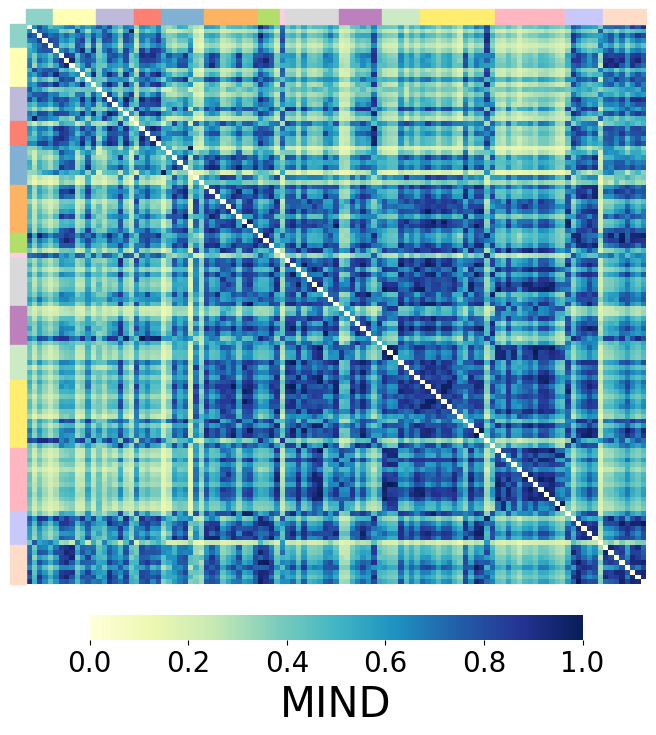

T1w/T2w MIND


/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:103: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((-3, i), 3, 1, color=row_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Left
/Users/EdHutchings_1/proj1/analyses/code/plotting_helpers.py:104: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(mpatches.Rectangle((i, -3), 1, 3, color=col_colors[i], clip_on=False, lw=1, edgecolor='face'))  # Top


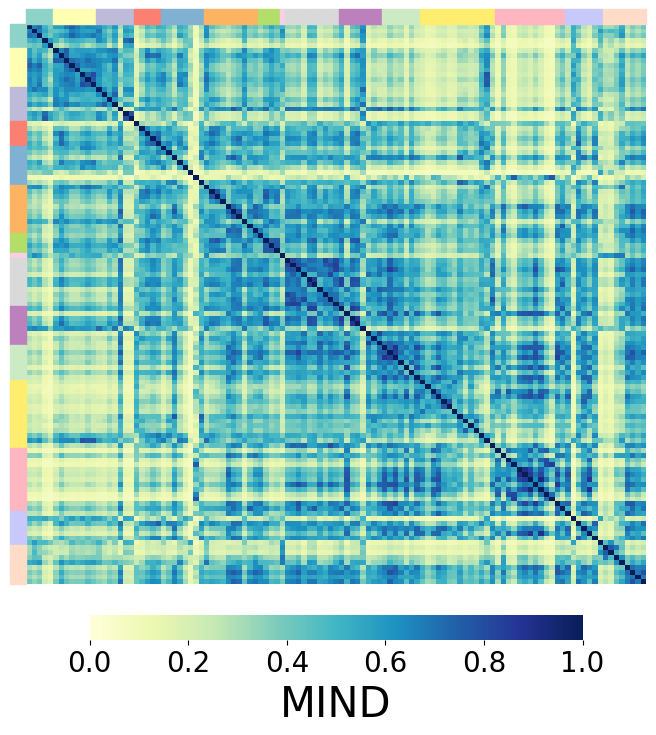

In [ ]:
print('MBP MIND')
MBP_4Y_MIND = pd.read_csv('output/MBP/MBP_4Y_MIND.csv', index_col=0)

matrix_plot(MBP_4Y_MIND, 
            edge_cmap='YlGnBu', diverging=False, 
            cbar_label='MIND', 
            patches=True, boundaries=False, labels=False,
            save_path=None)

print('T1w/T2w MIND')
adult_t12_MIND = pd.read_csv('output/T1wT2w/mean/mean_adult_t12_MIND.csv', index_col=0)

matrix_plot(adult_t12_MIND, 
            edge_cmap='YlGnBu', diverging=False, 
            cbar_label='MIND', 
            patches=True, boundaries=False, labels=False,
            save_path=None)

Quantitatively compare matrices by correlating upper triangles 

In [7]:
# ----- Load anatomical data ----- #

# Mean T1w/T2w
adult_mean_t12 = pd.read_csv('output/T1wT2w/mean/mean_adult_regional_t12.csv', index_col=0)
adult_mean_t12 = adult_mean_t12[adult_mean_t12.columns[0]].values

# Distance
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)


# ----- Compute edge-wise correlation ----- #

r, p = get_brainsmashed_edge_correlation_p_val(mat_a = adult_t12_MIND.iloc[0:115,0:115].values, 
                                               mat_b = MBP_4Y_MIND.iloc[0:115,0:115].values, 
                                               regions_ind = None, 
                                               map_a = adult_mean_t12[0:115],
                                               dist = dist.iloc[0:115,0:115].values, 
                                               surrogates_filename = 'output/surrogates/mean_adult_t12_surrogates_lh.csv', 
                                               n_perm = 1000, 
                                               test_type = 'upper')

if p < 0.001: 
    p_text = '< 0.001' 
else: 
    p_text = f'= {p:.3f}'

print(f'\nSpearman r = {r:.2f}, p {p_text}')

Generating null matrices


100%|██████████| 1000/1000 [00:04<00:00, 217.91it/s]


Generating null statistics


100%|██████████| 1000/1000 [00:01<00:00, 904.94it/s]


Spearman r = 0.40, p < 0.001


Now for each region, correlate MIND edges across modalities to assess which areas of cortex are most correspondent across modalities in terms of their similarity

Then, correlate regional cross-modal correspondence with position in cortical hierarchy

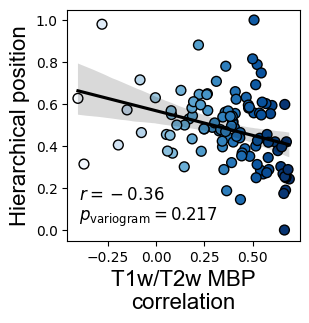

In [ ]:
# Re-load regions
lut = pd.read_csv('data/lut_master.csv', index_col=0)
labs = lut['Label']

# Loop lh ROIs, calculate correlation between MBP MIND edges and T1w/T2w MIND edges
r_list = []
for i in range(int(len(labs)/2)):
    roi_r, _ = spearmanr(MBP_4Y_MIND.iloc[i,:], adult_t12_MIND.iloc[i,:])
    r_list.append(roi_r)

# Correlate with position in cortical hierarchy
dist = pd.read_csv('data/distance_matrix.csv', index_col=0)

SA_position_correlation(to_plot = np.array(r_list), 
                        dist = dist.values[0:115,0:115],
                        surrogates_filename = 'output/surrogates/MBP_t12_MIND_regional_correlation_surrogates_lh.csv',
                        n_perm=1000,
                        test_type='two-tailed',
                        x_lab='T1w/T2w MBP\ncorrelation', 
                        colour_points_by='x', 
                        cmap='Blues', 
                        title_stats=False, 
                        location='bottom left',
                        save_path=None)
